/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 209MB/s] 


Epoch 1/20 - Train Acc: 0.9774, Val Acc: 0.9946
Epoch 2/20 - Train Acc: 0.9892, Val Acc: 0.9954
Epoch 3/20 - Train Acc: 0.9919, Val Acc: 0.9942
Epoch 4/20 - Train Acc: 0.9927, Val Acc: 0.9926
Epoch 5/20 - Train Acc: 0.9941, Val Acc: 0.9950
Epoch 6/20 - Train Acc: 0.9941, Val Acc: 0.9942
Epoch 7/20 - Train Acc: 0.9950, Val Acc: 0.9947
Epoch 8/20 - Train Acc: 0.9958, Val Acc: 0.9919
Epoch 9/20 - Train Acc: 0.9953, Val Acc: 0.9927
Epoch 10/20 - Train Acc: 0.9963, Val Acc: 0.9951
Epoch 11/20 - Train Acc: 0.9964, Val Acc: 0.9960
Epoch 12/20 - Train Acc: 0.9966, Val Acc: 0.9947
Epoch 13/20 - Train Acc: 0.9965, Val Acc: 0.9948
Epoch 14/20 - Train Acc: 0.9972, Val Acc: 0.9964
Epoch 15/20 - Train Acc: 0.9969, Val Acc: 0.9931
Epoch 16/20 - Train Acc: 0.9972, Val Acc: 0.9939
Epoch 17/20 - Train Acc: 0.9968, Val Acc: 0.9949
Epoch 18/20 - Train Acc: 0.9975, Val Acc: 0.9953
Epoch 19/20 - Train Acc: 0.9980, Val Acc: 0.9956
Epoch 20/20 - Train Acc: 0.9976, Val Acc: 0.9962


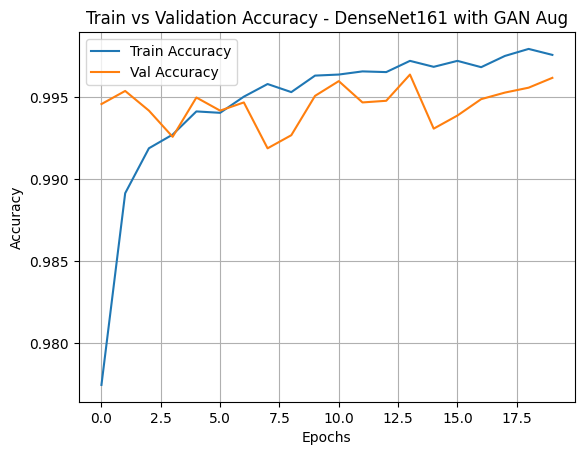


✅ Test Accuracy: 0.9953

Classification Report DenseNet161 with GAN Aug:
                    precision    recall  f1-score   support

       ANTHRACNOSE       1.00      0.99      0.99      1634
           DIEBACK       1.00      1.00      1.00      1664
  GALLMILDGEDAMAGE       0.99      1.00      1.00      1596
           HEALTHY       1.00      1.00      1.00      1793
INSECTDAMAGEWEBBER       0.99      0.99      0.99      1671
        LEAFBLIGHT       0.99      0.99      0.99      1643

          accuracy                           1.00     10001
         macro avg       1.00      1.00      1.00     10001
      weighted avg       1.00      1.00      1.00     10001



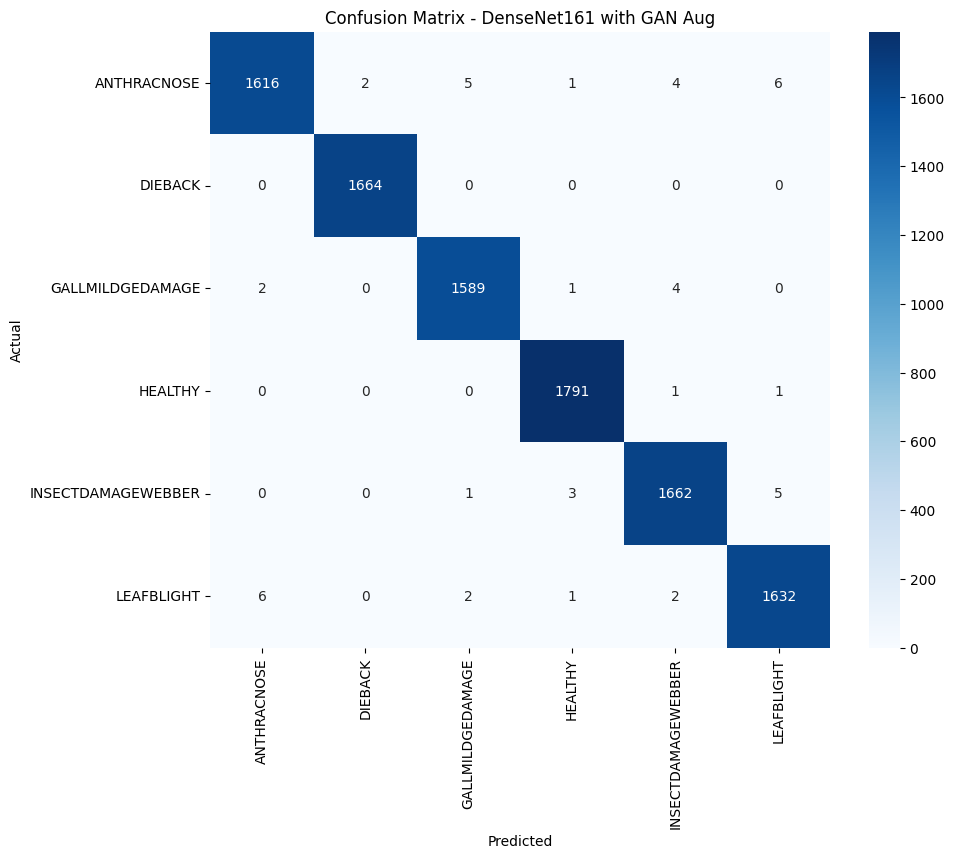

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset directories
train_dir = '/kaggle/input/rgan224x224/REALGANAUGMENTED224x224/train'
val_dir = '/kaggle/input/rgan224x224/REALGANAUGMENTED224x224/val'
test_dir = '/kaggle/input/rgan224x224/REALGANAUGMENTED224x224/test'

# Hyperparameters
NUM_CLASSES = 6
BATCH_SIZE = 16
NUM_EPOCHS = 20
LR = 1e-4

# Transforms (no augmentation)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=base_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=base_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=base_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load DenseNet-161 model
model = models.densenet161(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, NUM_CLASSES)
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training function
def train_model():
    history = {'train_acc': [], 'val_acc': []}
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_acc'].append(epoch_acc.item())

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_loader.dataset)
        history['val_acc'].append(val_acc.item())
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")
    return history

# Train model
history = train_model()

# Plot accuracy
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Train vs Validation Accuracy - DenseNet161 with GAN Aug')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Test accuracy
test_accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")

# Classification report
class_names = test_dataset.classes
print("\nClassification Report DenseNet161 with GAN Aug:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix - DenseNet161 with GAN Aug")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [2]:
import os
import shutil
# =====================
# 💾 Save Model in All Formats
# =====================
os.makedirs('/kaggle/working/saved_models', exist_ok=True)

# 1. Full model (HDF5)
model.save('/kaggle/working/saved_models/RMANGO_DenseNet161.h5')

# 2. Weights only
model.save_weights('/kaggle/working/saved_models/RMANGO_DenseNet161.weights.h5')

shutil.make_archive('/kaggle/working/mango_models_RMANGO_DenseNet161', 'zip', '/kaggle/working/saved_models')
print("\n✅ All models saved and zipped at /kaggle/working/mango_models_RMANGO_DenseNet161.zip")

AttributeError: 'DenseNet' object has no attribute 'save'

In [3]:
import torch
import os
import shutil

# 📂 Directory to save model files
save_dir = '/kaggle/working/saved_models'
os.makedirs(save_dir, exist_ok=True)

# 🧠 Assuming 'model' is your trained PyTorch model (e.g., torchvision.models.densenet201)
# Example: model = torchvision.models.densenet201(pretrained=False)

# 1️⃣ Save the full model
full_model_path = os.path.join(save_dir, 'RMANGO_DenseNet161_full.pth')
torch.save(model, full_model_path)

# 2️⃣ Save only the model weights (state_dict)
weights_path = os.path.join(save_dir, 'RMANGO_DenseNet161_weights.pth')
torch.save(model.state_dict(), weights_path)

# 📦 Zip the saved_models directory
zip_output_path = '/kaggle/working/mango_models_RMANGO_DenseNet161'
shutil.make_archive(zip_output_path, 'zip', save_dir)

print(f"\n✅ Model saved successfully:")
print(f"   - Full model: {full_model_path}")
print(f"   - Weights only: {weights_path}")
print(f"   - Zipped: {zip_output_path}.zip")


✅ Model saved successfully:
   - Full model: /kaggle/working/saved_models/RMANGO_DenseNet161_full.pth
   - Weights only: /kaggle/working/saved_models/RMANGO_DenseNet161_weights.pth
   - Zipped: /kaggle/working/mango_models_RMANGO_DenseNet161.zip
